# 앙상블 및 불균형 데이터 처리

본 챕터에서는 Bagging, Boosting 그리고 불균형 데이터에 대해 알아보고 실습하겠습니다.   

Bagging의 대표적 알고리즘인 Random forest, Boosting의 대표적 알고리즘인 AdaBoost 그리고 불균형 데이터 (Class imbalance)에 대해 알아보겠습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [2]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
pip install -U imbalanced-learn

In [3]:
def my_cv_fit(model, 
              X, y,
             grid,
              test_size=0.3,
              n_splits= 10, n_repeats= 3,
              scoring = 'accuracy'
             ):
    # train_test split (test_size= 0.3)하고 train 데이터를 다시 train_validation으로 나눠서 최적  hyper-parameter 구하기
    # estimator = model
    # GridSearchCV scoring = 'accuracy'를 사용.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size)
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    # grid:
    # 함수 인자로 받음.
    # estimator 선언
    # model 함수 인자로 받음.

    # hyper parameter tunning
    gscv = GridSearchCV(model, grid, scoring= scoring, cv=cv, n_jobs=-1)
    results = gscv.fit(X_train, y_train)
    print(results.best_params_)
    
    # (3) 최종 KNN 모델 선언 및 학습
    # 위에서 구한 best model을 사용합니다.
    # knn = KNeighborsClassifier(n_neighbor=5) 또는 results.best_estimator_ 사용
    best_estimator = results.best_estimator_

    # (4) confusion matrix 출력 및 결과 해석
    y_train_hat = best_estimator.predict(X_train)
    y_test_hat = best_estimator.predict(X_test)
    
    
    print('Train Data')
    print('정확도: ', round(accuracy_score(y_train, y_train_hat),3))
    print('재현율: ', recall_score(y_train, y_train_hat, average =None))
    print('정밀도:', precision_score(y_train, y_train_hat, average =None))


    print('Test Data')
    print('정확도: ', round(accuracy_score(y_test, y_test_hat),3))
    print('재현율: ', recall_score(y_test, y_test_hat, average =None))
    print('정밀도:', precision_score(y_test, y_test_hat, average =None))

    return results

## 데이터 

본 실습에서는 iris 데이터를 사용하겠습니다.

In [4]:
# 데이터 불러오기
from sklearn.datasets import load_iris

iris = load_iris()

In [5]:
iris['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
# target {0.0, 1.0, 2.0}  를 각각 {setosa, versicolor, viginica} 으로 매핑
df['target'] = df['target'].map({0:"setosa", 1:"versicolor", 2:"virginica"})
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
X, y = df[df.columns.drop('target')], df[['target']]
# train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Random forest

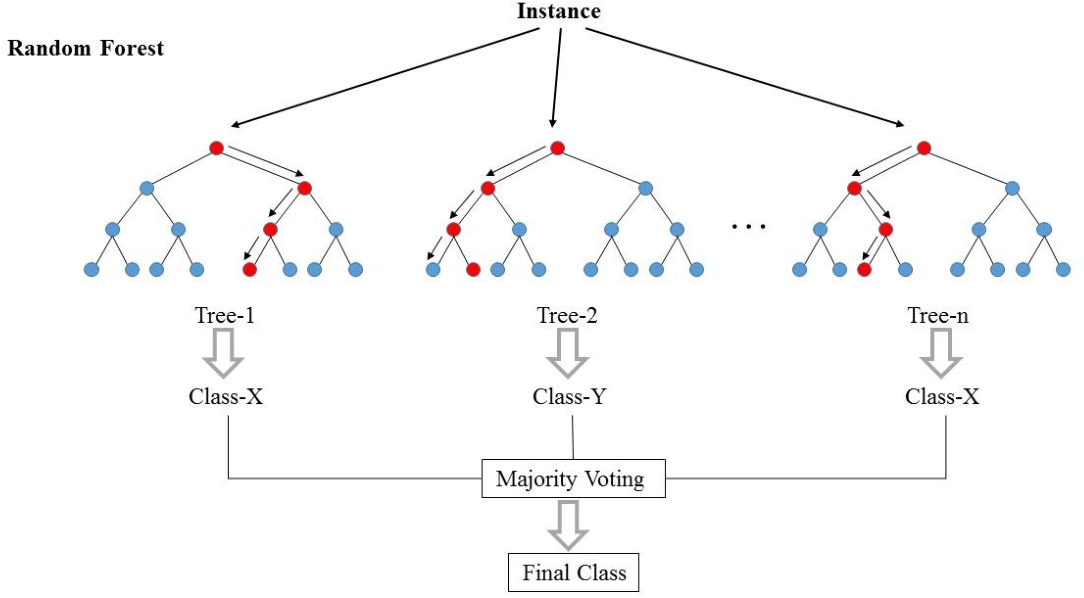

In [8]:
Image("random forest.png")

* 랜덤 포레스트(RF)는 트리 모델을 앙상블한 것입니다. 
* 각 트리는 독립적으로 다시 샘플링된 데이터 세트의 값에 따라 달라집니다.
* Generalization error 는 개별 트리의 예측 성능와 트리의 상관 관계에 따라 달라집니다.
* 분류에서 중요한 변수에 대한 추정치 (featrue importance) 를 제공합니다.

본 챕터에서는 Random forest classifier를 파이썬으로 실습해보겠습니다.

주요 hyper-parameter는 다음과 같습니다.
> n_estimators: The number of trees in the forest. default= 100   
max_depth: The maximum depth of the tree.     
min_samples_leaf: The minimum number of samples required to split an internal node         
criterion{"gini","entropy"}, default="gini"  

In [9]:
# 다음 명령어를 사용해서 Random forest 라이브러리를 가져올 수 있습니다.
from sklearn.ensemble import RandomForestClassifier

In [10]:
# 모델 선언
rf = RandomForestClassifier()

In [11]:
# 모델 학습
rf.fit(X_train, y_train)

<ipython-input-11-f59b99985bc6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier()

In [12]:
# 모델 예측
y_hat = rf.predict(X_train)

In [13]:
# 예측값 5개 출력
y_hat[:5]

array(['versicolor', 'setosa', 'setosa', 'virginica', 'virginica'],
      dtype=object)

In [14]:
# confusion matrix
confusion_matrix(y_train, y_hat)

array([[36,  0,  0],
       [ 0, 35,  0],
       [ 0,  0, 34]], dtype=int64)

In [15]:
# confusion matrix for the test set
confusion_matrix(y_test, rf.predict(X_test))

array([[14,  0,  0],
       [ 0, 14,  1],
       [ 0,  4, 12]], dtype=int64)

이미 학습이 잘 되었지만 복습을 위해서 GridSearch 및 CV를 사용해 보도록하겠습니다.     
tuning을 할 hyper-parameter는 n_estimators와 max_depth 입니다.    
선택지로는 다음을 고려하도록 합니다.  
> grid = {'n_estimators':[50, 100, 150, 200], 'max_depth':[2,3,4]}

In [16]:
# todo에 해당하는 빈 칸을 채워 넣으시면 됩니다.

# train_test split (test_size= 0.3)하고 train 데이터를 다시 train_validation으로 나눠서 최적  hyper-parameter 구하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

# Cross validation 설정.
# 5 folds를 한 번씩만 반복하는 것으로 설정해주세요.
cv = RepeatedKFold(n_splits=, n_repeats=, random_state=1) # todo


# grid 설정.
grid = #todo

# estimator 선언
# estimator = Randomforest
model = #todo

# hyper parameter tunning
# GridSearchCV scoring = 'accuracy'를 사용.
gscv =  GridSearchCV(estimator=  ,param_grid= , scoring= , cv=  , n_jobs=-1) # todo
results = gscv.fit(X_train, y_train)
print(results.best_params_)

# (3) 최종 KNN 모델 선언 및 학습
# 위에서 구한 best model을 사용합니다.
# knn = KNeighborsClassifier(n_neighbor=5) 또는 results.best_estimator_ 사용
best_estimator = # todo

# (4) confusion matrix 출력 및 결과 해석
y_train_hat = best_estimator.predict(X_train)
y_test_hat = best_estimator.predict(X_test)


# Multi-class 에 대한 recall, 정밀도를 프린트 하기 위해 average= None 사용.
print('Train Data')
print('정확도: ', round(accuracy_score(y_train, y_train_hat),3))
print('재현율: ', recall_score(y_train, y_train_hat, average =None))
print('정밀도:', precision_score(y_train, y_train_hat, average =None))


print('Test Data')
print('정확도: ', round(accuracy_score(y_test, y_test_hat),3))
print('재현율: ', recall_score(y_test, y_test_hat, average =None))
print('정밀도:', precision_score(y_test, y_test_hat, average =None))

SyntaxError: invalid syntax (<ipython-input-16-4e99265d078f>, line 8)

### 답안지

In [17]:
# train_test split (test_size= 0.3)하고 train 데이터를 다시 train_validation으로 나눠서 최적  hyper-parameter 구하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

# CV 옵션 설정.
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1) #todo

# grid 설정.
grid = {'n_estimators':[50, 100, 150, 200], 'max_depth':[2,3,4]} #todo

# estimator 선언
# estimator = Randomforest
model = RandomForestClassifier()#todo

# hyper parameter tunning
# GridSearchCV scoring = 'accuracy'를 사용
gscv = GridSearchCV(model, grid, scoring= 'accuracy', cv=cv, n_jobs=-1) # todo
results = gscv.fit(X_train, y_train)
print(results.best_params_)

# (3) 최종 KNN 모델 선언 및 학습
# 위에서 구한 best model을 사용합니다.
# knn = KNeighborsClassifier(n_neighbor=5) 또는 results.best_estimator_ 사용
best_estimator = results.best_estimator_# todo

# (4) confusion matrix 출력 및 결과 해석
y_train_hat = best_estimator.predict(X_train)
y_test_hat = best_estimator.predict(X_test)

# Multi-class 에 대한 recall, 정밀도를 프린트 하기 위해 average= None 사용.
print('Train Data')
print('정확도: ', round(accuracy_score(y_train, y_train_hat),3))
print('재현율: ', recall_score(y_train, y_train_hat, average =None))
print('정밀도:', precision_score(y_train, y_train_hat, average =None))


print('Test Data')
print('정확도: ', round(accuracy_score(y_test, y_test_hat),3))
print('재현율: ', recall_score(y_test, y_test_hat, average =None))
print('정밀도:', precision_score(y_test, y_test_hat, average =None))

{'max_depth': 2, 'n_estimators': 50}
Train Data
정확도:  0.943
재현율:  [1.         0.94594595 0.89473684]
정밀도: [1.         0.8974359  0.94444444]
Test Data
정확도:  0.978
재현율:  [1.         1.         0.91666667]
정밀도: [1.         0.92857143 1.        ]


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


#### 학습한 Random forest를 이용해서 Feature importance를 분석할 수 있습니다.

In [18]:
best_estimator

RandomForestClassifier(max_depth=2, n_estimators=50)

In [19]:
# feature importance
feature_importance = best_estimator.feature_importances_
feature_importance

array([0.04946286, 0.01816024, 0.40884045, 0.52353645])

In [20]:
# feature name
feature_name = X.columns.to_numpy()
feature_name

array(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'], dtype=object)

<ipython-input-21-df50e1d96ce1>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_name)
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


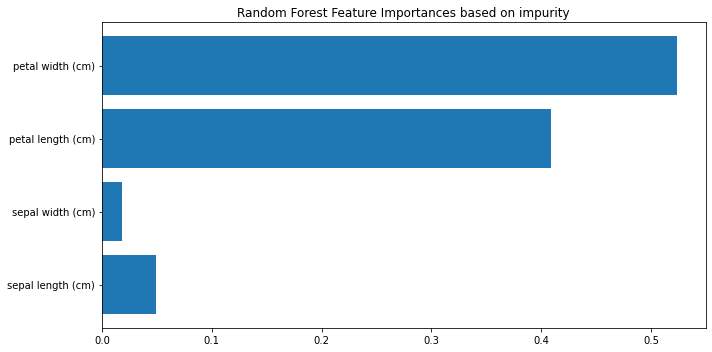

In [21]:
# 시각화
fig, ax = plt.subplots(figsize=(10,5))
y_ticks = np.arange(0, len(feature_name))
ax.barh(y_ticks, feature_importance)
ax.set_yticklabels(feature_name)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances based on impurity")
fig.tight_layout()
plt.show()

In [22]:
# feature importance를 정렬하면 좀 더 깔끔할 것 같습니다.
sorted_idx= feature_importance.argsort() # 내림 차순 정렬
sorted_idx

array([1, 0, 2, 3], dtype=int64)

<ipython-input-23-b06a99c83012>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_name[sorted_idx])


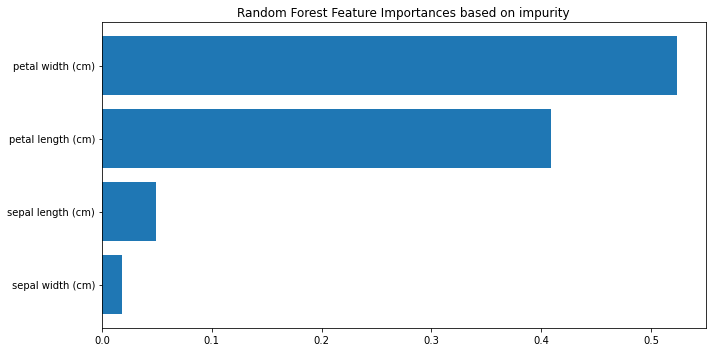

In [23]:
# 시각화
fig, ax = plt.subplots(figsize=(10,5))
y_ticks = np.arange(0, len(feature_name[sorted_idx]))
ax.barh(y_ticks, feature_importance[sorted_idx])
ax.set_yticklabels(feature_name[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances based on impurity")
fig.tight_layout()
plt.show()

## Adaptive Boosting (AdaBoost)

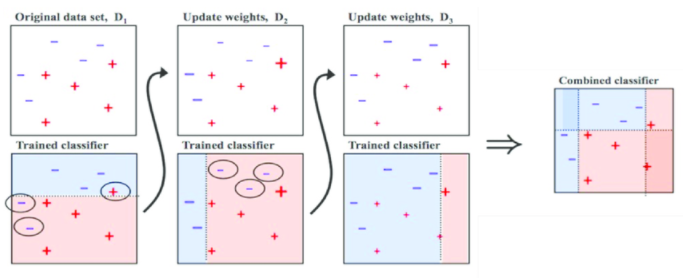

In [24]:
Image("adaboost.png")

"잘 틀리는 문제"에 학습 가중치를 갱신해 가며 학습을 하는 구조입니다.  
자세한 설명은 아래 주석을 해지하고 실행하시면 보실 수 있습니다.    
수업에서 다룰 주요 파라미터는, n_estimators 와 learning_rate 입니다.

In [25]:
# ?AdaBoostClassifier

In [26]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
adaboost = AdaBoostClassifier(n_estimators=20, learning_rate = 0.1)
adaboost.fit(X, y)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier(learning_rate=0.1, n_estimators=20)

In [35]:
# Esimators information
print(adaboost.estimator_weights_)
print(adaboost.estimator_errors_)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.33333333 0.18043041 0.2296828  0.13263458 0.13947379 0.08693928
 0.08335657 0.07330701 0.05120464 0.05446528 0.04486263 0.03511837
 0.03848088 0.03227092 0.0259623  0.02923475 0.02514832 0.02039913
 0.02353149 0.02058148]


In [36]:
# list of trees in adabosst
adaboost.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=1244166132),
 DecisionTreeClassifier(max_depth=1, random_state=2124019244),
 DecisionTreeClassifier(max_depth=1, random_state=1955506509),
 DecisionTreeClassifier(max_depth=1, random_state=1708891515),
 DecisionTreeClassifier(max_depth=1, random_state=1462082241),
 DecisionTreeClassifier(max_depth=1, random_state=751212491),
 DecisionTreeClassifier(max_depth=1, random_state=765210839),
 DecisionTreeClassifier(max_depth=1, random_state=16667355),
 DecisionTreeClassifier(max_depth=1, random_state=1874802950),
 DecisionTreeClassifier(max_depth=1, random_state=148083601),
 DecisionTreeClassifier(max_depth=1, random_state=629416871),
 DecisionTreeClassifier(max_depth=1, random_state=940592723),
 DecisionTreeClassifier(max_depth=1, random_state=1261910089),
 DecisionTreeClassifier(max_depth=1, random_state=809870601),
 DecisionTreeClassifier(max_depth=1, random_state=125082494),
 DecisionTreeClassifier(max_depth=1, random_state=1808012351),
 

In [37]:
# feature importance
feature_importance_ada = adaboost.feature_importances_
print(feature_importance_ada)

[0.  0.  0.4 0.6]


<ipython-input-38-c6ed612086a5>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_name[sorted_idx])


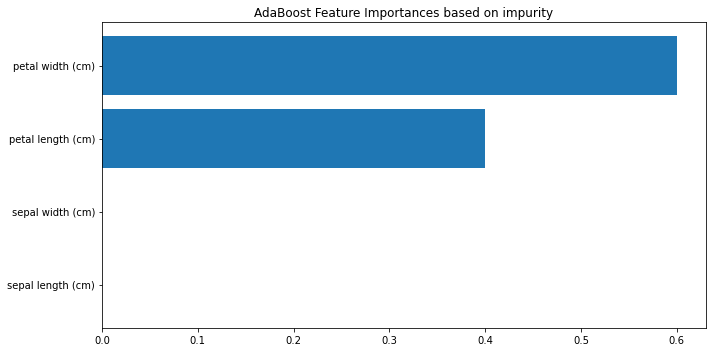

In [38]:
import matplotlib.pyplot as plt
sorted_idx = feature_importance_ada.argsort()
y_ticks = np.arange(0, len(feature_name))
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(y_ticks, feature_importance_ada[sorted_idx])
ax.set_yticklabels(feature_name[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("AdaBoost Feature Importances based on impurity")
fig.tight_layout()
# plt.tight_layout()
plt.show()

In [39]:
# 모델 예측
y_pred = adaboost.predict(X)


In [40]:
# Confusion matrix
con_mat = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)
# f1 = f1_score(y, y_pred)
print(con_mat)

[[50  0  0]
 [ 0 49  1]
 [ 0 10 40]]


## 데이터 불균형 문제 (Class imbalance)

데이터 불균형 문제 (Class imbalance)는 특히 분류 문제에서 흔한 문제입니다. 불균형 데이터는 모델 정확성을 크게 방해합니다.     
데이터가 불균형한 경우 다수 클래스를 예측하는 것만으로도 상당히 높은 정확도를 얻을 수 있지만 소수 클래스에 대한 데이터 패턴을 학습하지 못합니다.    
    
 
> 대표적인 해결 방법으로는 Over-sampling, Under-sampling 그리고 Penalize Algorithms (Cost-Sensitive Training)   
이 있습니다.
    
본 챕터에서는 imblearn 이라는 python package를 사용해서 Over-sampling 과 Under-sampling을 실습해보겠습니다. 

In [49]:
# pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.8.1-py3-none-any.whl (189 kB)
Note: you may need to restart the kernel to use updated packages.


### 1. Naive random over-sampling

In [3]:
# 데이터 불러오기 
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [4]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

In [23]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [26]:
from collections import Counter
print(sorted(Counter(y_train).items()))

[(0, 48), (1, 196), (2, 3506)]


In [27]:
print(sorted(Counter(y_resampled).items()))

[(0, 3506), (1, 3506), (2, 3506)]


#### 학습 성능 차이 비교

In [21]:
from sklearn.svm import LinearSVC
# 1. resampled data 를 사용한 경우
clf = LinearSVC()
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

In [28]:
# 2. 있는 그대로 사용한 경우
clf_2 = LinearSVC()
clf_2.fit(X_resampled, y_resampled)
y_hat_2 = clf.predict(X_test)

In [29]:
confusion_matrix(y_test, y_hat)

array([[   0,    1,   15],
       [   1,    4,   61],
       [   3,   55, 1110]], dtype=int64)

In [30]:
confusion_matrix(y_test, y_hat_2)

array([[   4,    7,    5],
       [   0,   51,   15],
       [   0,    1, 1167]], dtype=int64)

왜 위와 같은 결과가 나왔는 지 직관적으로 이해하기 위해 다음 figure를 참고해주세요.
![CV](resampling.png)

참고로 oversampling 은 string 변수에 대해서도 활용이 가능합니다.    
다음 예시를 참고해주세요.

In [34]:
X_hetero = np.array([['xxx', 1, 1.0], ['yyy', 2, 2.0], ['zzz', 3, 3.0]],
                    dtype=object)
y_hetero = np.array([0, 0, 1])
X_hetero

array([['xxx', 1, 1.0],
       ['yyy', 2, 2.0],
       ['zzz', 3, 3.0]], dtype=object)

In [35]:
X_resampled, y_resampled = ros.fit_resample(X_hetero, y_hetero)
print(X_resampled)

[['xxx' 1 1.0]
 ['yyy' 2 2.0]
 ['zzz' 3 3.0]
 ['zzz' 3 3.0]]


In [32]:
print(y_resampled)

[0 0 1 1]


### 2. SMOTE

Over-sampling 기법 중 가장 널리 쓰이는 기법입니다.   
알고리즘의 핵심 아이디어는 KNN 이며, 다음 그림을 참고해주세요.   
![CV](SMOTE.png)

In [36]:
from imblearn.over_sampling import SMOTE

In [38]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [39]:
print(sorted(Counter(y_resampled).items()))

[(0, 3506), (1, 3506), (2, 3506)]


In [40]:
clf_smote = LinearSVC().fit(X_resampled, y_resampled)

In [41]:
y_hat_3 = clf_smote.predict(X_test)

In [42]:
confusion_matrix(y_test, y_hat_3)

array([[  10,    1,    5],
       [   9,   52,    5],
       [   8,   27, 1133]], dtype=int64)

In [43]:
# simple random over-sampling 과 비교.
confusion_matrix(y_test, y_hat_2)

array([[   4,    7,    5],
       [   0,   51,   15],
       [   0,    1, 1167]], dtype=int64)

### 3. Under-sampling

다양한 under-sampling 기법 중 가장 단순한, RandomUnderSampler 를 실습해보겠습니다.     
RandomUnderSampler는 대상 클래스에 대한 subset 을 임의로 선택하여 calss imbalance 문제를 빠르고 쉽게 해결합니다.

In [44]:
from imblearn.under_sampling import RandomUnderSampler

In [46]:
rus = RandomUnderSampler(random_state=0)

In [47]:
X_resampled, y_resampled = rus.fit_resample(X, y)

In [50]:
# under-sampling 전
print(sorted(Counter(y).items()))

[(0, 64), (1, 262), (2, 4674)]


In [51]:
# under-sampling 후
print(sorted(Counter(y_resampled).items()))

[(0, 64), (1, 64), (2, 64)]


In [52]:
# 모델 학습
clf_under = LinearSVC().fit(X_resampled, y_resampled)

In [53]:
# 모델 예측
y_hat_4 = clf_under.predict(X_test)

In [54]:
# 모델 평가
confusion_matrix(y_test, y_hat_4)

array([[  10,    1,    5],
       [   9,   52,    5],
       [   8,   71, 1089]], dtype=int64)

In [55]:
# SMOTE 결과와 비교
confusion_matrix(y_test, y_hat_3)

array([[  10,    1,    5],
       [   9,   52,    5],
       [   8,   27, 1133]], dtype=int64)